In [1]:
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale

%matplotlib inline

In [2]:
help(minmax_scale)

Help on function minmax_scale in module sklearn.preprocessing._data:

minmax_scale(X, feature_range=(0, 1), *, axis=0, copy=True)
    Transform features by scaling each feature to a given range.
    
    This estimator scales and translates each feature individually such
    that it is in the given range on the training set, i.e. between
    zero and one.
    
    The transformation is given by (when ``axis=0``)::
    
        X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        X_scaled = X_std * (max - min) + min
    
    where min, max = feature_range.
    
    The transformation is calculated as (when ``axis=0``)::
    
       X_scaled = scale * X + min - X.min(axis=0) * scale
       where scale = (max - min) / (X.max(axis=0) - X.min(axis=0))
    
    This transformation is often used as an alternative to zero mean,
    unit variance scaling.
    
    Read more in the :ref:`User Guide <preprocessing_scaler>`.
    
    .. versionadded:: 0.17
       *minmax_scale* fu

In [3]:
plt.rc('font', family = 'serif', size = 13, weight = "bold")
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', linewidth = 2)
plt.rc('lines', linewidth = 3)
plt.rc('figure', figsize = (6, 6))
plt.rc('legend', fontsize = 13)

cm = plt.cm.get_cmap('tab20')

In [4]:
# 37C data
filename = "/Users/kuanlin/OneDrive - Johns Hopkins University/DATA/20210301_SGrO1_scale_genconc_t7conc/data.xlsx"
data1 = pd.read_excel(filename, sheet_name = "data")

data1.columns

Index(['1xG1xt7', '2xG1xt7', '1xG2xt7', '2xG2xt7'], dtype='object')

## Transcription Fitting

- **Components (y)**: Scafold Genlet (SG), P(RNA product), Q:F(quenched flourophore complex, Q: quencher, F: flourophore), P:Q(RNA:quencher complex), F(signal)


- **Rates (p)**: $K_{p} = 0.02 (\frac{1}{s})$, $K_{7bp} = \frac{1e^{4}}{1e^{9}} (\frac{1}{nM*s})$, using transcription Rate from Sam


- **Reactions**:

    $ SG \stackrel{k_{p}}{\rightarrow} SG + P $
    
    $ P + Q:F \stackrel{k_{7bp}}{\rightarrow} P:Q + F $


- **ODEs**:

    $\frac{d[SG]}{dt}=0$

    $\frac{d[P]}{dt}=K_{p}[SG]-K_{7bp}[P][Q:F]$

    $\frac{d[Q:F]}{dt}=-K_{7bp}[P][Q:F]$
    
    $\frac{d[P:Q]}{dt}=K_{7bp}[P][Q:F]$
    
    $\frac{d[F]}{dt}=K_{7bp}[P][Q:F]$
    
    

In [5]:
def transcription(init_vals, params, t):
    SG0, P0, QF0, PQ0, F0 = init_vals
    SG, P, QF, PQ, F = [SG0], [P0], [QF0], [PQ0], [F0]
    Kp, K7bp = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        nextSG = SG[-1]
        nextP = P[-1] + (Kp*SG[-1] - K7bp*P[-1]*QF[-1])*dt
        nextQF = QF[-1] - (K7bp*P[-1]*QF[-1])*dt
        nextPQ = PQ[-1] + (K7bp*P[-1]*QF[-1])*dt
        nextF = F[-1] + (K7bp*P[-1]*QF[-1])*dt
        SG.append(nextSG); P.append(nextP); QF.append(nextQF); PQ.append(nextPQ); F.append(nextF)
    return np.stack([SG, P, QF, PQ, F]).T

## 37C Transcription Data

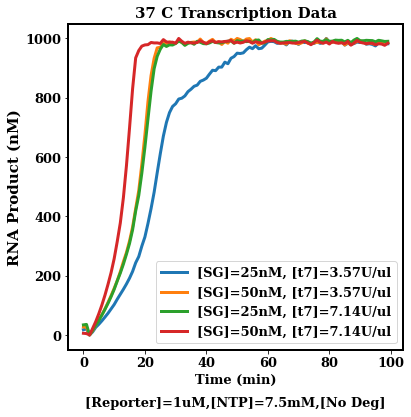

In [6]:
plt.plot(minmax_scale(data1["1xG1xt7"][:100])*1000, label = "[SG]=25nM, [t7]=3.57U/ul")
plt.plot(minmax_scale(data1["2xG1xt7"][:100])*1000, label = "[SG]=50nM, [t7]=3.57U/ul")
plt.plot(minmax_scale(data1["1xG2xt7"][:100])*1000, label = "[SG]=25nM, [t7]=7.14U/ul")
plt.plot(minmax_scale(data1["2xG2xt7"][:100])*1000, label = "[SG]=50nM, [t7]=7.14U/ul")
plt.title("37 C Transcription Data", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("Time (min)\n[Reporter]=1uM,[NTP]=7.5mM,[No Deg]", weight = "bold", fontsize = 13, linespacing = 2)
plt.ylabel("RNA Product (nM)", weight = "bold", fontsize = 15)
plt.xticks(fontsize = 13, weight = 'bold')
plt.yticks(fontsize = 13, weight = 'bold')
plt.ylim(-50, 1050)
plt.legend()
plt.show()


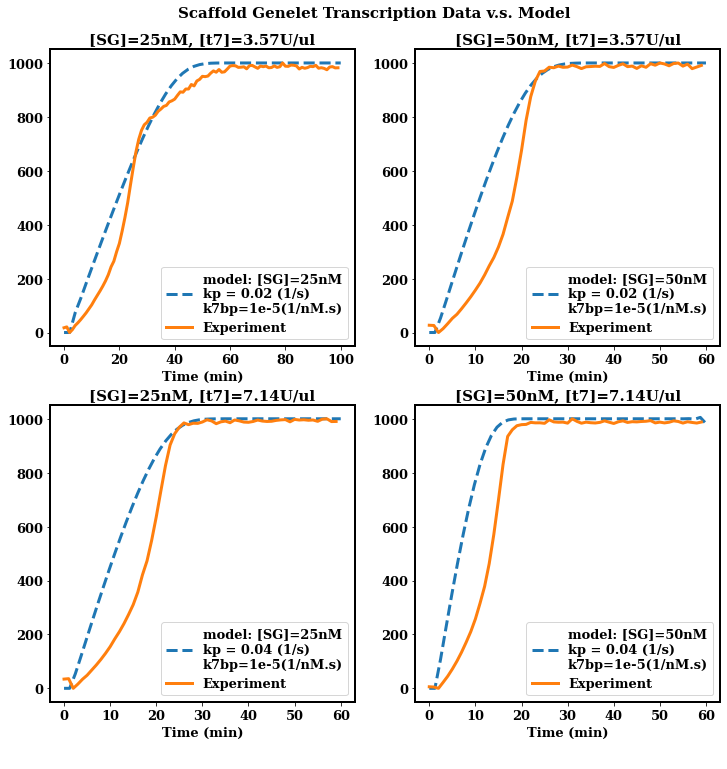

In [7]:
fig = plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)

time = np.linspace(0, 6000); dat = transcription([25, 0, 1000, 0, 0], [0.02, 1e4/1e9], time)[:, 3]
plt.plot(time / 60, dat, ls = "--", label = "model: [SG]=25nM\nkp = 0.02 (1/s)\nk7bp=1e-5(1/nM.s)")
plt.plot(minmax_scale(data1["1xG1xt7"][:100])*1000, label = "Experiment")
plt.title("[SG]=25nM, [t7]=3.57U/ul", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("Time (min)\n", weight = "bold", fontsize = 13, linespacing = 2)
plt.xticks(fontsize = 13, weight = 'bold')
plt.yticks(fontsize = 13, weight = 'bold')
plt.ylim(-50, 1050)
plt.legend(loc=4)

plt.subplot(2, 2, 2)

time = np.linspace(0, 3600); dat = transcription([50, 0, 1000, 0, 0], [0.02, 1e4/1e9], time)[:, 3]
time = np.linspace(0, 3600); dat2 = transcription([50, 0, 1000, 0, 0], [0.05, 8.5e-7], time)[:, 3]
plt.plot(time / 60, dat, ls = "--", label = "model: [SG]=50nM\nkp = 0.02 (1/s)\nk7bp=1e-5(1/nM.s)")
plt.plot(minmax_scale(data1["2xG1xt7"][:60])*1000, label = "Experiment")
plt.title("[SG]=50nM, [t7]=3.57U/ul", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("Time (min)\n", weight = "bold", fontsize = 13, linespacing = 2)
plt.xticks(fontsize = 13, weight = 'bold')
plt.yticks(fontsize = 13, weight = 'bold')
plt.ylim(-50, 1050)
plt.legend(loc=4)

plt.subplot(2, 2, 3)

time = np.linspace(0, 3600); dat = transcription([25, 0, 1000, 0, 0], [0.04, 1e4/1e9], time)[:, 3]
plt.plot(time / 60, dat, ls = "--", label = "model: [SG]=25nM\nkp = 0.04 (1/s)\nk7bp=1e-5(1/nM.s)")
plt.plot(minmax_scale(data1["1xG2xt7"][:60])*1000, label = "Experiment")
plt.title("[SG]=25nM, [t7]=7.14U/ul", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("Time (min)\n", weight = "bold", fontsize = 13, linespacing = 2)
plt.xticks(fontsize = 13, weight = 'bold')
plt.yticks(fontsize = 13, weight = 'bold')
plt.ylim(-50, 1050)
plt.legend(loc=4)

plt.subplot(2, 2, 4)

time = np.linspace(0, 3600); dat = transcription([50, 0, 1000, 0, 0], [0.04, 1e4/1e9], time)[:, 3]
plt.plot(time / 60, dat, ls = "--", label = "model: [SG]=50nM\nkp = 0.04 (1/s)\nk7bp=1e-5(1/nM.s)")
plt.plot(minmax_scale(data1["2xG2xt7"][:60])*1000, label = "Experiment")
plt.title("[SG]=50nM, [t7]=7.14U/ul", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("Time (min)\n", weight = "bold", fontsize = 13, linespacing = 2)
plt.xticks(fontsize = 13, weight = 'bold')
plt.yticks(fontsize = 13, weight = 'bold')
plt.ylim(-50, 1050)
plt.legend(loc=4)

fig.suptitle("Scaffold Genelet Transcription Data v.s. Model", fontsize = 15, weight = 'bold', y = .93)

plt.show()


## Bayesian Regression for Rate Distribution

In [53]:
import pickle
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import integrate
from pymc3.ode import DifferentialEquation
from sklearn.preprocessing import minmax_scale

print(az.__version__) # 0.10.0
print(pm.__version__) #  3.9.3

0.10.0
3.9.3


In [54]:
filename = "/Users/kuanlin/OneDrive - Johns Hopkins University/DATA/20210301_SGrO1_scale_genconc_t7conc/data.xlsx"
data1 = pd.read_excel(filename, sheet_name = "data")

data1.columns

Index(['1xG1xt7', '2xG1xt7', '1xG2xt7', '2xG2xt7'], dtype='object')

In [55]:
def transcription_fit(y, t, p):
    SG = y[0]; P = y[1]; QF = y[2]; PQ = y[3]; F = y[4]
    Kp = p[0]; K7bp = p[1]
    dSGdt = 0
    dPdt = Kp * SG - K7bp * P * QF
    dQFdt = - K7bp * P * QF
    dPQdt = K7bp * P * QF
    dFdt = K7bp * P*QF
    return [dSGdt, dPdt, dQFdt, dPQdt, dFdt]

In [56]:
# int_times = np.linspace(0, 3600, 60)

# fitdata = minmax_scale(data1["2xG1xt7"][:60])*1000

# init_vals = [50, 0, 1000, 0, 0]

# ode_model_transcription_fit = DifferentialEquation(
#     func = transcription_fit, times = int_times, n_states = 5, n_theta = 2, t0 = 0)

# with pm.Model() as G_transcription_fit:
#     # prior definition
#     Kp = pm.Lognormal('Kp', mu = -3.9, sigma = 1)
#     K7bp = pm.Lognormal('K7bp', mu = -11.5, sigma = 1)
#     sigma = pm.HalfCauchy('sigma', 0.1)
#     ode_solution = ode_model_transcription_fit(y0 = init_vals, theta = [Kp, K7bp])
#     Y = pm.Normal('Y', mu = ode_solution[:, 3], sigma = sigma, observed = fitdata)
    
#     trace = pm.sample(1000, tune = 1000, cores = 1)
    
#     np.save("2xG1xt7_trace.npy", trace)

In [57]:
# int_times = np.linspace(0, 3600, 60)

# fitdata = minmax_scale(data1["1xG2xt7"][:60])*1000

# init_vals = [25, 0, 1000, 0, 0]

# ode_model_transcription_fit = DifferentialEquation(
#     func = transcription_fit, times = int_times, n_states = 5, n_theta = 2, t0 = 0)

# with pm.Model() as G_transcription_fit:
#     # prior definition
#     Kp = pm.Lognormal('Kp', mu = -3.2, sigma = 1)
#     K7bp = pm.Lognormal('K7bp', mu = -11.5, sigma = 1)
#     sigma = pm.HalfCauchy('sigma', 0.1)
#     ode_solution = ode_model_transcription_fit(y0 = init_vals, theta = [Kp, K7bp])
#     Y = pm.Normal('Y', mu = ode_solution[:, 3], sigma = sigma, observed = fitdata)
    
#     trace = pm.sample(1000, tune = 1000, cores = 1)
    
#     np.save("1xG2xt7_trace.npy", trace)

In [58]:
# int_times = np.linspace(0, 6000, 100)

# fitdata = minmax_scale(data1["1xG1xt7"][:100])*1000

# init_vals = [25, 0, 1000, 0, 0]

# ode_model_transcription_fit = DifferentialEquation(
#     func = transcription_fit, times = int_times, n_states = 5, n_theta = 2, t0 = 0)

# with pm.Model() as G_transcription_fit:
#     # prior definition
#     Kp = pm.Lognormal('Kp', mu = -3.9, sigma = 1)
#     K7bp = pm.Lognormal('K7bp', mu = -11.5, sigma = 1)
#     sigma = pm.HalfCauchy('sigma', 0.1)
#     ode_solution = ode_model_transcription_fit(y0 = init_vals, theta = [Kp, K7bp])
#     Y = pm.Normal('Y', mu = ode_solution[:, 3], sigma = sigma, observed = fitdata)
    
#     trace = pm.sample(1000, tune = 1000, cores = 1)
    
#     np.save("1xG1xt7_trace.npy", trace)

In [59]:
# int_times = np.linspace(0, 3600, 60)

# fitdata = minmax_scale(data1["2xG2xt7"][:60])*1000

# init_vals = [50, 0, 1000, 0, 0]

# ode_model_transcription_fit = DifferentialEquation(
#     func = transcription_fit, times = int_times, n_states = 5, n_theta = 2, t0 = 0)

# with pm.Model() as G_transcription_fit:
#     # prior definition
#     Kp = pm.Lognormal('Kp', mu = -3.2, sigma = 1)
#     K7bp = pm.Lognormal('K7bp', mu = -11.5, sigma = 1)
#     sigma = pm.HalfCauchy('sigma', 0.1)
#     ode_solution = ode_model_transcription_fit(y0 = init_vals, theta = [Kp, K7bp])
#     Y = pm.Normal('Y', mu = ode_solution[:, 3], sigma = sigma, observed = fitdata)
    
#     trace = pm.sample(1000, tune = 1000, cores = 1)
    
#     np.save("2xG2xt7_trace.npy", trace)

## Bayesain Regression Results

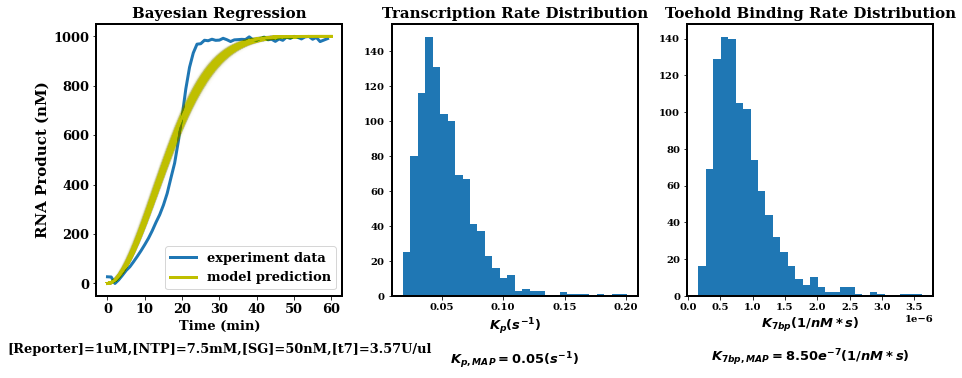

In [60]:
trace = np.load("2xG1xt7_trace.npy", allow_pickle = True)

Kps = [trace[i]["Kp"] for i in range(len(trace))]

K7bps = [trace[i]["K7bp"] for i in range(len(trace))]

int_times = np.linspace(0, 3600, 60)

fitdata = minmax_scale(data1["2xG1xt7"][:60])*1000

init_vals = [50, 0, 1000, 0, 0]


fig = plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
plt.plot(fitdata, label = "experiment data")

for i in range(len(trace)):
    arg_examp = (trace[i]['Kp'], trace[i]['K7bp'])
    vals_samp = integrate.odeint(transcription_fit, t = int_times, y0 = init_vals, args = (arg_examp, ))
    plt.plot(int_times / 60, vals_samp[:, 3], color = 'y', alpha = 0.01)
    if i==0:
        plt.plot(int_times / 60, vals_samp[:,3], color = 'y', alpha = 1, label = "model prediction")
        
plt.title("Bayesian Regression", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("Time (min)\n[Reporter]=1uM,[NTP]=7.5mM,[SG]=50nM,[t7]=3.57U/ul", weight = "bold", fontsize = 13, linespacing = 2)
plt.ylabel("RNA Product (nM)", weight = "bold", fontsize = 15)
plt.xticks(fontsize = 13, weight = 'bold')
plt.yticks(fontsize = 13, weight = 'bold')
plt.ylim(-50, 1050)
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(Kps, bins = 30);
plt.title("Transcription Rate Distribution", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("$K_{p} (s^{-1})$\n$K_{p, MAP} = {%.2f} (s^{-1})$"%(np.mean(Kps)), weight = "bold", fontsize = 13, linespacing = 2)

plt.subplot(1, 3, 3)
plt.hist(K7bps, bins = 30);
plt.title("Toehold Binding Rate Distribution", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("$K_{7bp} (1/nM*s)$\n$K_{7bp, MAP} = {%.2f}e^{-7} (1/nM*s)$"%(np.mean(K7bps)*1e7), weight = "bold", fontsize = 13, linespacing = 2)

plt.show()


## 25C Transcription Data

In [15]:
filename = "200nM_400nMSG_1x2xt7_1uMRep.xlsx"
data2 = pd.read_excel(filename, sheet_name = "data")

data2.columns

Index(['200_1x', '400_1x', '200_2x', '400_2x'], dtype='object')

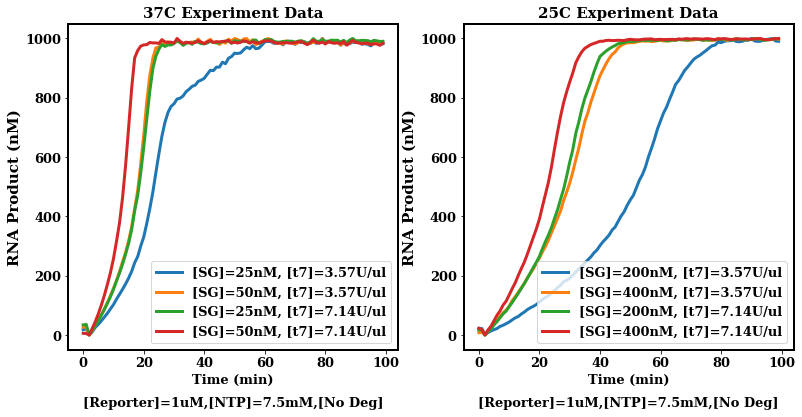

In [16]:
plt.figure(figsize = (13, 6))
plt.subplot(1, 2, 1)
plt.plot(minmax_scale(data1["1xG1xt7"][:100])*1000, label = "[SG]=25nM, [t7]=3.57U/ul")
plt.plot(minmax_scale(data1["2xG1xt7"][:100])*1000, label = "[SG]=50nM, [t7]=3.57U/ul")
plt.plot(minmax_scale(data1["1xG2xt7"][:100])*1000, label = "[SG]=25nM, [t7]=7.14U/ul")
plt.plot(minmax_scale(data1["2xG2xt7"][:100])*1000, label = "[SG]=50nM, [t7]=7.14U/ul")
plt.title("37C Experiment Data", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("Time (min)\n[Reporter]=1uM,[NTP]=7.5mM,[No Deg]", weight = "bold", fontsize = 13, linespacing = 2)
plt.ylabel("RNA Product (nM)", weight = "bold", fontsize = 15)
plt.xticks(fontsize = 13, weight = 'bold')
plt.yticks(fontsize = 13, weight = 'bold')
plt.ylim(-50, 1050)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(minmax_scale(data2["200_1x"][:100])*1000, label = "[SG]=200nM, [t7]=3.57U/ul")
plt.plot(minmax_scale(data2["400_1x"][:100])*1000, label = "[SG]=400nM, [t7]=3.57U/ul")
plt.plot(minmax_scale(data2["200_2x"][:100])*1000, label = "[SG]=200nM, [t7]=7.14U/ul")
plt.plot(minmax_scale(data2["400_2x"][:100])*1000, label = "[SG]=400nM, [t7]=7.14U/ul")
plt.title("25C Experiment Data", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("Time (min)\n[Reporter]=1uM,[NTP]=7.5mM,[No Deg]", weight = "bold", fontsize = 13, linespacing = 2)
plt.ylabel("RNA Product (nM)", weight = "bold", fontsize = 15)
plt.xticks(fontsize = 13, weight = 'bold')
plt.yticks(fontsize = 13, weight = 'bold')
plt.ylim(-50, 1050)
plt.legend()
plt.show()



## Rate Fitting with SymFit

see: https://symfit.readthedocs.io/en/stable/fitting_types.html#ode-fitting

Derivative(F, t; K7bp, Kp) = K7bp*P*QF
Derivative(P, t; K7bp, Kp) = -K7bp*P*QF + 50.0*Kp
Derivative(PQ, t; K7bp, Kp) = K7bp*P*QF
Derivative(QF, t; K7bp, Kp) = -K7bp*P*QF

Parameter Value        Standard Deviation
K7bp      1.000000e-05 1.283880e-05
Kp        1.335175e-02 3.583444e-03
Status message         b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Number of iterations   6
Objective              <symfit.core.objectives.LeastSquares object at 0x7ffd19efead0>
Minimizer              <symfit.core.minimizers.LBFGSB object at 0x7ffd19efeed0>

Goodness of fit qualifiers:
chi_squared            536883.9304128339
objective_value        268441.96520641696
r_squared              0.9391467833047535


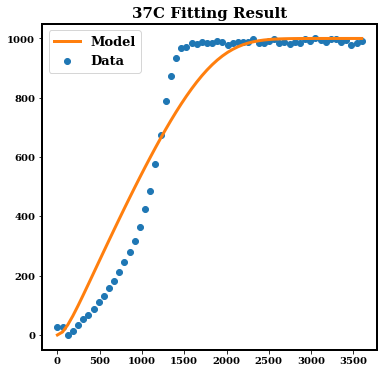

In [14]:
from symfit import variables, parameters, ODEModel, D, Fit, Parameter
from symfit.core.support import key2str
import numpy as np
import matplotlib.pyplot as plt

#Defining initial Data
tspan = np.linspace(0, 3600, 60)
Prod_data = minmax_scale(data1["2xG1xt7"][:60])*1000

# Define our ODE model
t, P, QF, PQ, F = variables('t, P, QF, PQ, F')
# Kp, K7bp = parameters('Kp, K7bp')
Kp = Parameter('Kp', value = 0.02, min = 0.00002, max = 20)
K7bp = Parameter('K7bp', value = 1e-5, fixed = True)

SG_0 = 50.0
QF_0 = 1000.0

model_dict = {
    D(P, t): Kp * SG_0 - K7bp * P * QF,
    D(QF, t): - K7bp * P * QF,
    D(PQ, t): K7bp * P * QF,
    D(F, t): K7bp * P * QF,
}

model = ODEModel(
    model_dict,
    initial = {t: 0.0, P: 0.0, QF: QF_0, PQ: 0.0, F: 0.0}
)
print(model)

fit = Fit(model, t = tspan, P = None, QF = None, PQ = None, F = Prod_data) 
fit_result = fit.execute()
print(fit_result)

#Graphing Results
taxis = np.linspace(0, 3600, 60)
model_fit = model(t = taxis, **fit_result.params)._asdict()
plt.scatter(tspan, Prod_data, label='Data')
plt.plot(taxis, model_fit[F], label = 'Model', color = cm.colors[2])
plt.title("37C Fitting Result", weight = "bold", fontsize = 15, y = 1)
plt.legend()
plt.show()

Derivative(F, t; K7bp, Kp) = K7bp*P*QF
Derivative(P, t; K7bp, Kp) = -K7bp*P*QF + 400.0*Kp
Derivative(PQ, t; K7bp, Kp) = K7bp*P*QF
Derivative(QF, t; K7bp, Kp) = -K7bp*P*QF

Parameter Value        Standard Deviation
K7bp      1.000000e-05 8.330981e-06
Kp        9.176671e-04 1.051484e-04
Status message         b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Number of iterations   6
Objective              <symfit.core.objectives.LeastSquares object at 0x7f8f3e7be150>
Minimizer              <symfit.core.minimizers.LBFGSB object at 0x7f8f3e7be850>

Goodness of fit qualifiers:
chi_squared            439685.1777643918
objective_value        219842.5888821959
r_squared              0.9674047583370772


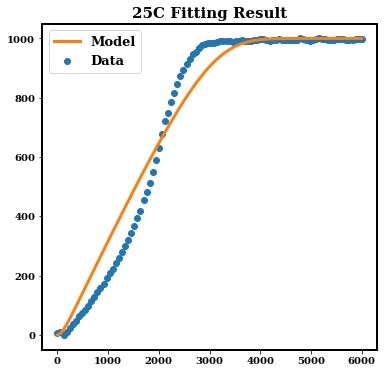

In [62]:
from symfit import variables, parameters, ODEModel, D, Fit, Parameter
from symfit.core.support import key2str
import numpy as np
import matplotlib.pyplot as plt

#Defining initial Data
tspan = np.linspace(0, 6000, 100)
Prod_data = minmax_scale(data2["400_1x"][:100])*1000

# Define our ODE model

t, P, QF, PQ, F = variables('t, P, QF, PQ, F')
# Kp, K7bp = parameters('Kp, K7bp')

Kp = Parameter('Kp', value = 0.02, min = 0.00002, max = 20)
K7bp = Parameter('K7bp', value = 1e-5, fixed = True)

SG_0 = 400.0
QF_0 = 1000.0

model_dict = {
    D(P, t): Kp * SG_0 - K7bp * P * QF,
    D(QF, t): - K7bp * P * QF,
    D(PQ, t): K7bp * P * QF,
    D(F, t): K7bp * P * QF,
}

model = ODEModel(
    model_dict,
    initial = {t: 0.0, P: 0.0, QF: QF_0, PQ: 0.0, F: 0.0}
)
print(model)

fit = Fit(model, t = tspan, P = None, QF = None, PQ = None, F = Prod_data) 
fit_result = fit.execute()
print(fit_result)

#Graphing Results
taxis = np.linspace(0, 6000, 100)
model_fit = model(t = taxis, **fit_result.params)._asdict()
plt.scatter(tspan, Prod_data, label='Data')
plt.plot(taxis, model_fit[F], label = 'Model', color = cm.colors[2])
plt.title("25C Fitting Result", weight = "bold", fontsize = 15, y = 1)
plt.legend()
plt.show()

### Transcription Fitting
|-|25C|37C|Sam's Model|
|-|-|-|-|
|**Transcription Rate (1/s)**|9.176671e-04|1.335175e-02|0.02|

- roughly 20X lower at 25C

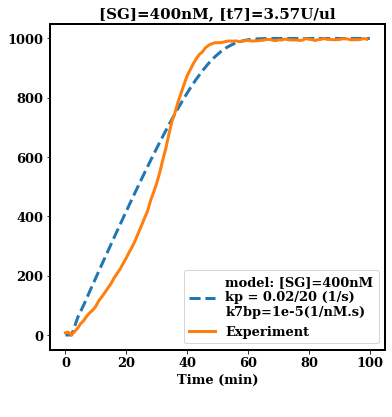

In [63]:
time = np.linspace(0, 6000); dat = transcription([400, 0, 1000, 0, 0], [0.02/20, 1e4/1e9], time)[:, 3]
plt.plot(time / 60, dat, ls = "--", label = "model: [SG]=400nM\nkp = 0.02/20 (1/s)\nk7bp=1e-5(1/nM.s)")
plt.plot(minmax_scale(data2["400_1x"][:100])*1000, label = "Experiment")
plt.title("[SG]=400nM, [t7]=3.57U/ul", weight = "bold", fontsize = 15, y = 1)
plt.xlabel("Time (min)\n", weight = "bold", fontsize = 13, linespacing = 2)
plt.xticks(fontsize = 13, weight = 'bold')
plt.yticks(fontsize = 13, weight = 'bold')
plt.ylim(-50, 1050)
plt.legend(loc=4)
plt.show()

## ODE Fitting with lmfit (not good due to dt too big...)

In [17]:
def transcription(init_vals, params, t):
    SG0, P0, QF0, PQ0, F0 = init_vals
    SG, P, QF, PQ, F = [SG0], [P0], [QF0], [PQ0], [F0]
    Kp, K7bp = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        nextSG = SG[-1]
        nextP = P[-1] + (Kp*SG[-1] - K7bp*P[-1]*QF[-1])*dt
        nextQF = QF[-1] - (K7bp*P[-1]*QF[-1])*dt
        nextPQ = PQ[-1] + (K7bp*P[-1]*QF[-1])*dt
        nextF = F[-1] + (K7bp*P[-1]*QF[-1])*dt
        
        if nextP < 0: nextP = 0
        if nextQF < 0: nextQF = 0
        if nextPQ > init_vals[2]: nextPQ = init_vals[2]
        if nextF > init_vals[2]: nextF = init_vals[2]
        
        SG.append(nextSG); P.append(nextP); QF.append(nextQF); PQ.append(nextPQ); F.append(nextF)
        
#         print(dt, nextSG, nextP, nextQF, nextPQ, nextF)
                
    return np.stack([SG, P, QF, PQ, F]).T


transcription([50, 0, 1000, 0, 0], [0.02, 1e5/1e9], np.linspace(0, ts*60, len(tspan)))[:, 3]/1000

NameError: name 'ts' is not defined

In [ ]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

params = Parameters()
params.add('Kp', value = 0.02, min = 0, max = 0.2)
# params.add('K5bp', value = 1e-6)

ts = 60

tspan = data1["t"].values[:ts]; Prod_data = data1["{}_tra".format(ls[-3])].values[:ts]

def residual(ps, ts, data):
    Kp = ps['Kp'].value
    model = transcription([50, 0, 1000, 0, 0], [Kp, 1e-4], np.linspace(0, ts[-1]*60, len(ts)))[:, 3]/1000
    return (model - data).ravel()

result = minimize(residual, params, args = (tspan, Prod_data), method = 'leastsq')

# display fitted statistics
report_fit(result)

